# 자연어처리 기술을 활용한 사회 주요 이슈 분석 및 여론 예측 모델(SNU GSDS Lee yoon seop)

# TASK 1. 온라인 환경에서 긍/부정 국민 여론 예측모델(Korea Public Opinion Prediction Model)

## Import

In [ ]:
! pip install transformers
! pip install emoji
! pip install hanja

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import random
import math
import warnings
warnings.filterwarnings(action='ignore') 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(">> Using {}".format(device))

# Plots style
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=12)

from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
plot_template = dict(
    layout=go.Layout({
        "font_size": 15,
        "xaxis_title_font_size": 15,
        "yaxis_title_font_size": 15}))

# data processing
import urllib.request
import re, string
import emoji
import hanja
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# Transformers
from transformers import AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

>> Using cuda


<Figure size 432x288 with 0 Axes>

# Overall Pipeline
    - STEP 1) 감성분석 말뭉치 준비 : 긍ㆍ부정 라벨링 된 트위터 및 댓글 텍스트
    - STEP 2) 텍스트 임베딩 분류모델 파인튜닝 : 3가지 방식으로 텍스트 임베딩(또는 벡터)을 생성ㆍ분류할 수 있도록 설계한 BERT 기반 언어모델을 학습
    - STEP 3) 시계열 데이터 변환 : 언어모델의 긍ㆍ부정 예측값을 시계열 테이블로 변환
    - STEP 4) 트랜스포머 시계열 예측모델 적용 : Transformers 기반으로 설계한 시계열 데이터 예측모델로 학습 後 미래의 긍ㆍ부정 여론 추이 예측
    
    
    To summarize the entire process of the 『Online Public Opinion Prediction Model』 we designed, it consists of the following four steps.
    - STEP 1) Sentiment analysis corpus preparation: positive/negative labeled Twitter and comment text
    - STEP 2) Fine-tuning a text embedding classification model: learn a BERT-based language model designed to create and classify text embeddings (or vectors) in three ways
    - STEP 3) Time series data conversion: Convert the positive/negative predictive values of the language model into a time series table
    - STEP 4) Applying a Transformers-based time series prediction model: Predict the future trend of positive/negative public opinion after learning with my time series data prediction model designed based on Transformers

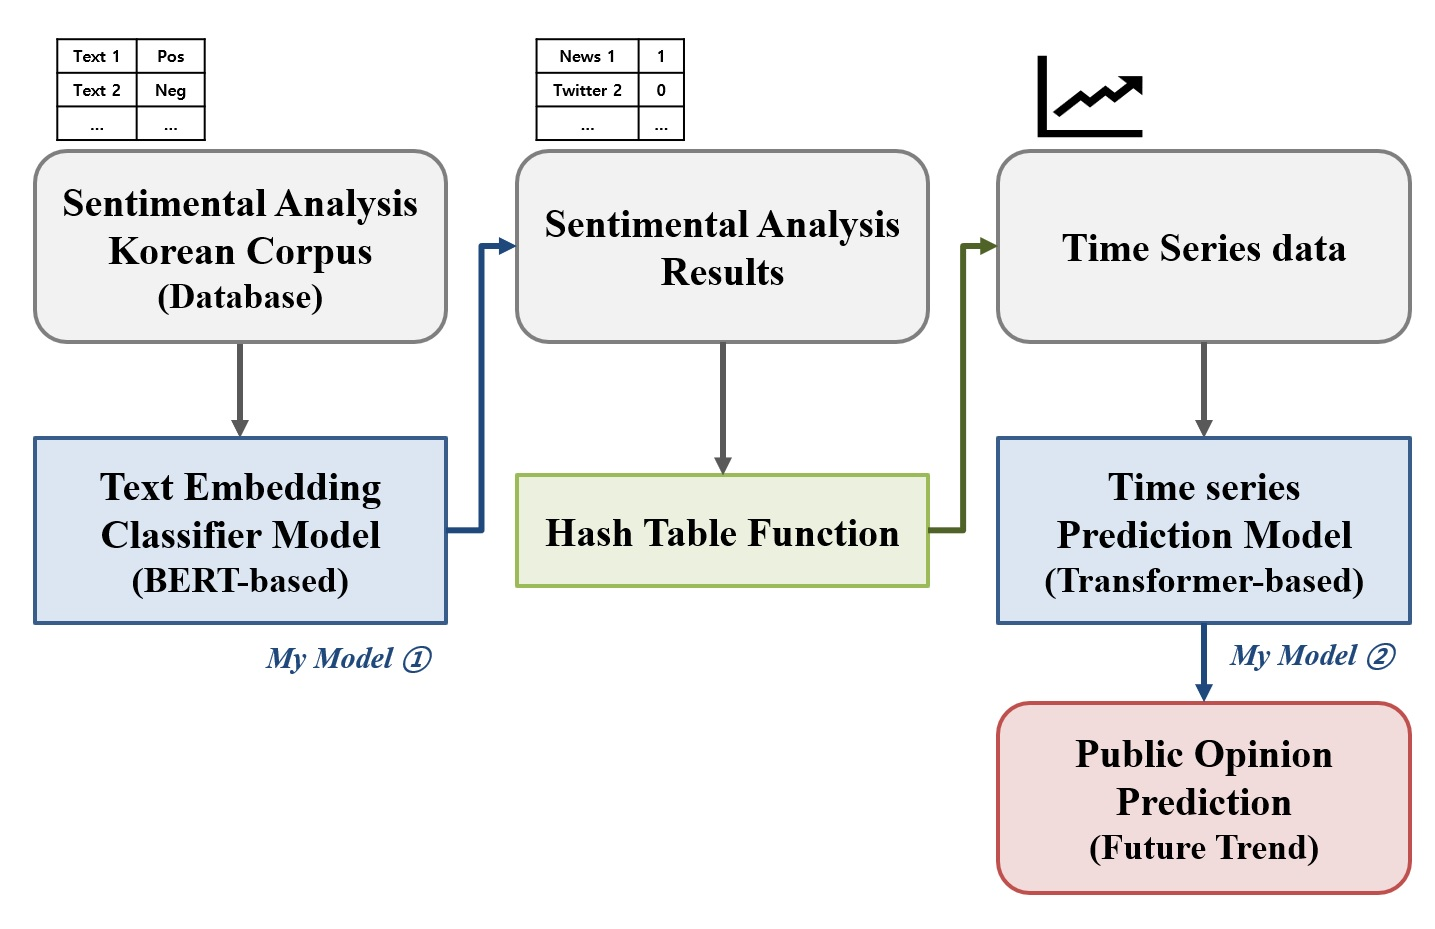

# STEP 1. 감성분석 말뭉치 준비(Sentiment analysis corpus preparation)
    - 국회에서 제공한 입법 관련 뉴스, 트위터 그리고 감성분석을 위해 자체 수집한 온라인 댓글 등 총 53만개의 텍스트 데이터를 종합하고 전처리하였다.
    - 해당 텍스트 데이터를 긍ㆍ부정 여론에 따라 라벨링(부정:0, 긍정:1)하였다.

    - A total of 530k text data, including legislative news and Twitter, provided by the Korea National Assembly, and online comments collected for sentiment analysis, were synthesized and pre-processed.
    - This text data was labeled (negative: 0, positive: 1) according to positive and negative public opinion.

## 1-1. 트위터 데이터 전처리(Text Preprocessing)

In [5]:
# Load my Sentiment Dataset
train_data_path = 'data/train_data.csv'
test_data_path = 'data/test_data.csv'

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
print(" >> Train data size :", len(train_df))
print(" >> Test data size :", len(test_df))
train_df.tail()

 >> Train data size : 522519
 >> Test data size : 7948


,Unnamed: 0,Text,Sentiment
522514,522514,"임대차 3법은 오히려 지금 필요한데, 인수위에서 거론되는 것은 임대차3법을 폐지하겠...",1
522515,522515,"윤호중, 인수위 임대차3법 폐지 축소에 대단한 혼란 올 것.",1
522516,522516,임대차 3법 아마 지금 한바퀴 돌아 효과나오기 직전일건데 그걸 또 없앤다고.,1
522517,522517,윤석렬정부의 임대차3법 폐지는 민생파기. 안정적인 전월세 또 급등 우려. 민간임대부...,1
522518,522518,집이나 상가 임대하여 살거나 영업하시는 분들 열 받게 생겼네. 임대차 3법을 윤석열...,1


In [6]:
# 1. Filtering Chinese characters
def cleansing_chinese(sent):
    # Chinese to Korean
    sent = hanja.translate(sent, 'substitution')
    return sent

# 2. Clean emojis
def clean_emoji(text):
    return emoji.replace_emoji(text)

# 3. Clean multi space
def clean_multi_space(text):
    text = str(text)
    return re.sub("\s\s+" , " ", text)

# 4. Filtering special characters and spaces
def cleansing_special(sent):
    sent = re.sub("[](),,ㆍ·\'\"’‘”“!?\\‘|\<\>`\'[\◇….]", " ", sent)
    sent = re.sub("[^가-힣a-zA-Z0-9\\s]", " ", sent)
    sent = re.sub("\s+", " ", sent)
    sent = sent.strip()
    return sent

# 5. Final Preprocessing
def cleansing_sent(sent):
    clean_sent = cleansing_chinese(sent)
    clean_sent = cleansing_special(clean_sent)
    clean_sent = clean_emoji(clean_sent)
    clean_sent = clean_multi_space(clean_sent)
    return clean_sent

# 6. Kor Text preprocessing samples
sentence = '[1] 文대통령이 "실언"했다는      北김여정…아슬아슬한 (남북관계).'
clean_sentence = cleansing_sent(sentence)

print(">> Before Preprocessing : {}".format(sentence))
print(">> After Preprocessing : {}".format(clean_sentence))

>> Before Preprocessing : [1] 文대통령이 "실언"했다는      北김여정…아슬아슬한 (남북관계).
>> After Preprocessing : 1 문대통령이 실언 했다는 북김여정 아슬아슬한 남북관계


In [7]:
# Text dataset
df = train_df[['Text', 'Sentiment']]
test_df = test_df[['Text', 'Sentiment']]

# Clean train data
cleaned_text = []
for text in df.Text:
    new_text = cleansing_sent(text)
    cleaned_text.append(new_text)

# Clean test data
cleaned_test = []
for text in test_df.Text:
    new_text = cleansing_sent(text)
    cleaned_test.append(new_text)

df['cleaned_text'] = cleaned_text
test_df['cleaned_text'] = cleaned_test

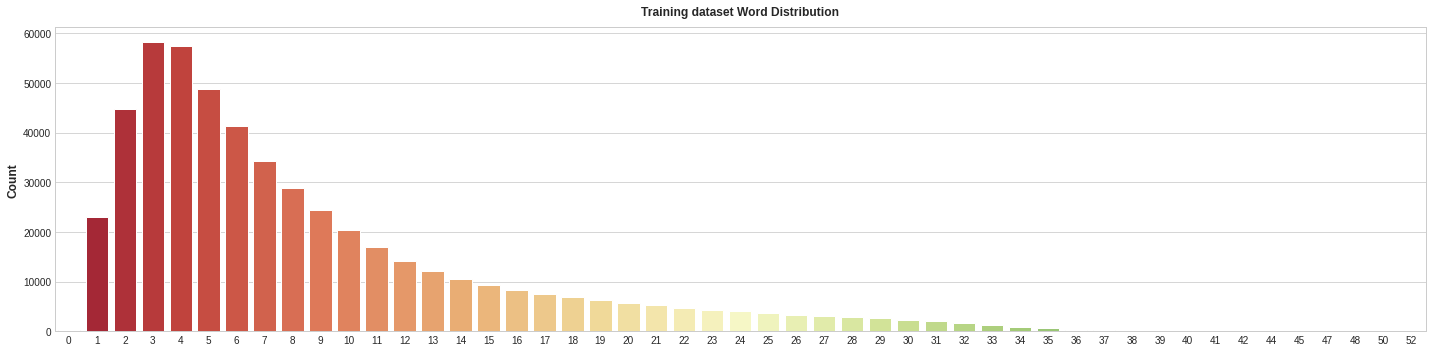

In [8]:
# Dataset Text length
text_len = []
for text in df.cleaned_text:
    t_len = len(text.split())
    text_len.append(t_len)

df['text_len'] = text_len

test_text_len = []
for text in test_df.cleaned_text:
    t_len = len(text.split())
    test_text_len.append(t_len)

test_df['text_len'] = test_text_len

plt.figure(figsize=(20, 5))
ax = sns.countplot(x = 'text_len',
                   data = df[df['text_len'] < 60],
                   palette = 'RdYlGn')
plt.title('Training dataset Word Distribution')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

In [9]:
# Drop empty tweets and less tahn 5 words
min_words = 1
max_words = 36

df = df[df['text_len'] > min_words]
df = df[df['text_len'] < max_words]
test_df = test_df[test_df['text_len'] > min_words]
test_df = test_df[test_df['text_len'] < max_words]
print(df['Sentiment'].value_counts())

# Over Sampling for sample ratio
ros = RandomOverSampler()
# Train data
train_x, train_y = ros.fit_resample(np.array(df['cleaned_text']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns =['cleaned_text', 'Sentiment'])

# Test data
test_x, test_y = ros.fit_resample(np.array(test_df['cleaned_text']).reshape(-1, 1), np.array(test_df['Sentiment']).reshape(-1, 1))
test_os = pd.DataFrame(list(zip([x[0] for x in test_x], test_y)), columns =['cleaned_text', 'Sentiment'])

print("\n ==== After Train dataset over sampling ==== \n")
print(train_os['Sentiment'].value_counts())

print("\n ==== After Test dataset over sampling ==== \n")
print(test_os['Sentiment'].value_counts())

1    255426
0    243143
Name: Sentiment, dtype: int64

 ==== After Train dataset over sampling ==== 

0    255426
1    255426
Name: Sentiment, dtype: int64

 ==== After Test dataset over sampling ==== 

0    3943
1    3943
Name: Sentiment, dtype: int64


In [10]:
# Train : Validation = 99 : 1 
X = train_os['cleaned_text'].values
y = train_os['Sentiment'].values

# Train & validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size = 0.01,
                                                      stratify = y,
                                                      random_state = 42)
# Test
X_test = test_df['cleaned_text'].values
y_test = test_df['Sentiment'].values

print(">> Training data : {}".format(X_train.shape[0]))
print(">> Validation data : {}".format(X_valid.shape[0]))
print(">> Test data : {}".format(X_test.shape[0]))

>> Training data : 505743
>> Validation data : 5109
>> Test data : 7565


## 1-2. 토크나이져(Tokenizer)

In [11]:
plm_model = 'klue/roberta-base'
tokenizer = AutoTokenizer.from_pretrained(plm_model)

def preprocessing_for_bert(data, max_len = 128):
    # 1. List to store outputs
    input_ids, att_masks = [], []
    for i in range(len(data)):
        encoded_sent = tokenizer.encode_plus(
            data[i],                           # Cleaned text
            add_special_tokens = True,         # Add [CLS], [SEP]
            max_length = max_len,              # Max length
            pad_to_max_length = True,          # The same size for MAX_LEN : Cut at this length or zero-pad
            return_attention_mask = True,      # Return attention mask
        )
    
        # Add the outputs to List
        input_ids.append(encoded_sent.get('input_ids'))
        att_masks.append(encoded_sent.get('attention_mask'))
    
    # Convert list -> Tensor
    input_ids = torch.tensor(input_ids)
    att_masks = torch.tensor(att_masks)

    return input_ids, att_masks

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [12]:
# Cheack Maximum token length
tok_lens = []
for text in df['cleaned_text'].values:
    tokens = tokenizer.encode(text, max_length = 512, truncation = True)
    tok_lens.append(len(tokens))

max_len = max(tok_lens)
print(">> MAX tokenized sentence lenghts : {}".format(max_len))

>> MAX tokenized sentence lenghts : 120


In [13]:
# Make token dataset(max_len = 128)
train_input_ids, train_att_masks = preprocessing_for_bert(X_train)
val_input_ids, val_att_masks = preprocessing_for_bert(X_valid)
test_input_ids, test_att_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


## 1-3. 데이터 로더(DataLoader)

In [14]:
# Convert label data to torch.Tensor
train_label = torch.tensor(y_train)
val_label = torch.tensor(y_valid)
test_label = torch.tensor(y_test)

# Batch
batch_size = 32

# DataLoader
train_data = TensorDataset(train_input_ids, train_att_masks, train_label)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_input_ids, val_att_masks, val_label)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

test_data = TensorDataset(test_input_ids, test_att_masks, test_label)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

# STEP 2. 텍스트 임베딩 분류모델 파인튜닝(Fine-tuning Text Embedding Classifier Model)

## 2-1. 텍스트 임베딩 분류 모델(Text Embedding Classification model)
    - 주요 특성 : 텍스트 임베딩 값을 얻기 위해 3가지 방식을 활용하여 모델의 유연성 및 텍스트 분류 성능을 높임.
        1) CLS Token : 문장 內 전체 토큰의 의미가 포함된 단어 단위 벡터
        2) Mean Pooling : 전체 토큰의 의미표현이 종합된 문장 단위 벡터
        3) Max Pooling : 중요한 토큰의 의미표현이 종합된 문장 단위 벡터


    - Using pre-trained BERT-based language models(PLMs), we can obtain a fixed-size contextual vector, which means Token Embedding.
    - Use the [CLS] token or apply a pooling technique to obtain sentence-level embedding instead of token-level embedding.
        1) [CLS] Token : A word-level vector containing the meaning of the entire token within a sentence.
        2) Mean Pooling : A sentence-level vector summarizing the semantic expression of all tokens
        3) Max Pooling : A sentence-level vector summarizing the semantic expression of important tokens.



In [15]:
#########################################
## 1. BERT-based Text classifier model ##
#########################################
class MyBERT_Classifier(nn.Module):
    def __init__(self, model_name, freeze_bert = False, embedding_type = "cls"):
        """
        model_name : Pre-trained language models
        embedding_type : 'cls', 'max', 'mean'
        """
        super(MyBERT_Classifier, self).__init__()

        D_in, H, D_out = 768, 64, 2      # [Hidden size of BERT, Hidden size of our classifier, Number of labels]
        
        self.emb_type = embedding_type
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.25),    
            nn.Linear(H, D_out),
        )
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    
    def forward(self, input_ids, att_masks):
        # 1.Token-based Fixed vector representation
        outputs = self.bert(input_ids = input_ids, attention_mask = att_masks)
        embeddings = outputs[0]                               # Token Embeddings : [num_text, token_max_length(512), PLM_hidden_dim(768)]
        mask = att_masks.unsqueeze(-1).expand(embeddings.size()).float()
        masked_embeddings = embeddings * mask
        
        # 2. Extract Text Embeddings (Three methods)
        # 2-1. Using [CLS] token 
        if self.emb_type == 'cls':
            # last hidden state [CLS]
            text_embeddings = masked_embeddings[:, 0, :]
            text_embeddings = text_embeddings.squeeze(0)      # [CLS] Toekn : [num_text, PLM_hidden_dim(768)] 
        # 2-2. Using Max Pooling
        elif self.emb_type == 'max':
            masked_embeddings[masked_embeddings == 0] = -1e9
            text_embeddings = torch.max(masked_embeddings, 1)[0]
            text_embeddings = text_embeddings.squeeze(0)      # Max Pooling Embeddings : [num_text, PLM_hidden_dim(768)] 
        # 2-3. Using Mean Pooling
        else:
            sum_emb = torch.sum(masked_embeddings, 1)
            counted = torch.clamp(mask.sum(1), min = 1e-9)
            text_embeddings = sum_emb / counted
            text_embeddings = text_embeddings.squeeze(0)      # Mean Pooling Embeddings  : [num_text, PLM_hidden_dim(768)] 
            
        # 3. Compute logits
        logits = self.classifier(text_embeddings)

        return logits


#############################
## 2. model Initialization ##
#############################
def initialize_model(model_name, epochs):
    
    bert_classifier = MyBERT_Classifier(
        model_name,
        freeze_bert = False,
        embedding_type = "cls"         # cls, mean, max
        )
    bert_classifier.to(device)

    optimizer = AdamW(
        bert_classifier.parameters(),
        lr = 1e-5,
        eps = 1e-7
        )
    
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps = 0,
        num_training_steps = total_steps
        )
    
    return bert_classifier, optimizer, scheduler


############################
## 3. Train & Evaluation  ##
############################

# Loss function & Validation score
loss_fn = nn.CrossEntropyLoss()
val_score = 1e-5

def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


# Training
def train(model, train_dataloader, val_dataloader, epochs, save_path, evaluation = False):
    val_score = 1e-5
    print("\n ******* Training ... ******* \n")
    
    for epoch_i in range(epochs):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("="*70)
        t0_epoch, t0_batch = time.time(), time.time()
        # 1. Reset tracking
        total_loss, batch_loss, batch_counts = 0, 0, 0
        # 2. training mode
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # 2-1. Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            # 2-2. Zero out any previously calculated gradients
            model.zero_grad()
            # 2-3. Logits
            logits = model(b_input_ids, b_attn_mask)
            # 2-4. Compute Loss
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            # 2-5. Calculate gradient, Backward pass
            loss.backward()
            # 2-6. Clip the norm of the gradients to 1.0 (prevent 'exploading gradient')
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # 2-7. Update parameters & learning rate
            optimizer.step()
            scheduler.step()

            # Print per 1000 STEPS
            if (step % 1000 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)


        # 3. Validation mode
        print("="*70)
        if evaluation == True:
            val_loss, val_accuracy, val_score = evaluate(model, val_dataloader, val_score, save_path)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("="*70)
        print("\n")
    print("Training complete !")


def evaluate(model, val_dataloader, val_score, save_path):
    print("  Validation score  ")
    # 3. Validation mode
    model.eval()
    # Tracking variables
    val_accuracy, val_loss = [], []

    for batch in val_dataloader:
        # 3-1. Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # 3-2. Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # 3-3. Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # 3-4. Get the predictions(Maximum)
        preds = torch.argmax(logits, dim=1).flatten()

        # 3-5. Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # 3-6. Compute the average accuracy and loss
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    # 3-7. Save best model
    if val_accuracy > val_score:
        val_score = val_accuracy
        if not os.path.isdir("models"):
            os.makedirs("models")
        torch.save(model.state_dict(), save_path)

    return val_loss, val_accuracy, val_score


def model_predict(model, test_dataloader):
    model.eval()
    model.to(device)
    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2] # No labels

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim = 0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim = 1)  # [num_text, num_classes]

    # Indices of the maximum probability of all classes
    preds = torch.argmax(probs, dim = 1).flatten().cpu().numpy()  # [maximum_prob_indices]

    return preds  

## 2-2. 감성분석을 위한 분류모델 학습(Train my model for sentimental analysis)

In [ ]:
set_seed(42)
additional_train = False
train_epochs = 5
save_path = './models/sentiment_model_cls.pt'    # _mean.pt, _max.pt, _cls.pt

if additional_train: 
    model, optimizer, scheduler = initialize_model(model_name = plm_model, epochs = train_epochs)
    model.load_state_dict(torch.load(save_path))
    model.to(device)
    train(model, train_dataloader, val_dataloader, epochs = train_epochs, save_path = save_path, evaluation = True)
else:
    model, optimizer, scheduler = initialize_model(model_name = plm_model, epochs = train_epochs)
    train(model, train_dataloader, val_dataloader, epochs = train_epochs, save_path = save_path, evaluation = True)

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for


 ******* Training ... ******* 

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
   1    |  1000   |   0.363431   |     -      |     -     |  657.96  
   1    |  2000   |   0.299898   |     -      |     -     |  661.88  
   1    |  3000   |   0.293743   |     -      |     -     |  662.61  
   1    |  4000   |   0.279199   |     -      |     -     |  662.57  
   1    |  5000   |   0.274038   |     -      |     -     |  662.22  
   1    |  6000   |   0.275341   |     -      |     -     |  662.59  
   1    |  7000   |   0.268231   |     -      |     -     |  662.15  
   1    |  8000   |   0.256135   |     -      |     -     |  662.29  
   1    |  9000   |   0.259589   |     -      |     -     |  662.40  
   1    |  10000  |   0.249138   |     -      |     -     |  661.86  
   1    |  11000  |   0.254463   |     -      |     -     |  660.83  
   1    |  12000  |   0.253607   |     -      |     -     |  661.90  
   1    |  13000  |   0.244261   |     -      |     -    

## 2-3. 분류모델의 성능 평가(Evaluate my model)
    - 모델 평가 결과, 3가지 방식 모두 91~92% 이상의 분류 정확도를 보여준다.
    - As a result of model evaluation, all three methods show classification accuracy of 91~92% or more.


In [ ]:
plm_model = 'klue/roberta-base'
save_path = './models/sentiment_model_cls.pt'

# CLS Token/Mean/Max Embeddings Prediction results
model = MyBERT_Classifier(plm_model, freeze_bert = False, embedding_type = "cls")
model.load_state_dict(torch.load(save_path))
test_preds = model_predict(model, test_dataloader)

# 10 Epochs(25% Dropout)
print('\n\n ===== Text Classification Report for [CLS] Token based - Embeddings ===== \n\n', 
      classification_report(y_test, test_preds, target_names = ['Negative', 'Positive']))

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for



 ===== Text Classification Report for [CLS] Token based - Embeddings ===== 

               precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      3622
    Positive       0.91      0.92      0.91      3943

    accuracy                           0.91      7565
   macro avg       0.91      0.91      0.91      7565
weighted avg       0.91      0.91      0.91      7565



In [18]:
plm_model = 'klue/roberta-base'
save_path = './models/sentiment_model_mean.pt'

# CLS Token/Mean/Max Embeddings Prediction results
model = MyBERT_Classifier(plm_model, freeze_bert = False, embedding_type = "mean")
model.load_state_dict(torch.load(save_path))
test_preds = model_predict(model, test_dataloader)

# 10 Epochs(25% Dropout)
print('\n\n ===== Text Classification Report for Mean Pooling based - Embeddings ===== \n\n', 
      classification_report(y_test, test_preds, target_names = ['Negative', 'Positive']))

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for



 ===== Text Classification Report for Mean Pooling based - Embeddings ===== 

               precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      3622
    Positive       0.91      0.92      0.92      3943

    accuracy                           0.91      7565
   macro avg       0.91      0.91      0.91      7565
weighted avg       0.91      0.91      0.91      7565



In [ ]:
plm_model = 'klue/roberta-base'
save_path = './models/sentiment_model_max.pt'

# CLS Token/Mean/Max Embeddings Prediction results
model = MyBERT_Classifier(plm_model, freeze_bert = False, embedding_type = "max")
model.load_state_dict(torch.load(save_path))
test_preds = model_predict(model, test_dataloader)

# 10 Epochs(25% Dropout)
print('\n\n ===== Text Classification Report for Max Pooling  based - Embeddings ===== \n\n', 
      classification_report(y_test, test_preds, target_names = ['Negative', 'Positive']))

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for



 ===== Text Classification Report for Max Pooling  based - Embeddings ===== 

               precision    recall  f1-score   support

    Negative       0.90      0.91      0.91      3622
    Positive       0.92      0.91      0.91      3943

    accuracy                           0.91      7565
   macro avg       0.91      0.91      0.91      7565
weighted avg       0.91      0.91      0.91      7565



## 2-3. 온라인 환경에서 긍/부정 여론 예측(eg. 임대차 3법 관련)

In [17]:
# Load preprocessed text dataset(News + Twitter) 
df = pd.read_csv('./data/clean_twitter_1.csv', encoding='utf-8')
df = df.dropna()
df = df.sort_values(by="Date")

# Extract prediction data(Twitter)
X_pred = df['Text'].values
print(">> Total Data size : ", len(X_pred))

# Tokenizer
pred_input_ids, pred_att_masks = preprocessing_for_bert(X_pred)

# DataLoader
batch_size = 32
pred_data = TensorDataset(pred_input_ids, pred_att_masks)
pred_dataloader = DataLoader(pred_data, batch_size = batch_size)

# Positive/negative prediction through fine-tuned language model
plm_model = 'klue/roberta-base'
save_path = './models/sentiment_model_cls.pt'

model = MyBERT_Classifier(plm_model, freeze_bert = False, embedding_type = "cls")
model.load_state_dict(torch.load(save_path))
twitter_preds = model_predict(model, pred_dataloader)
print("\n Prediction complete ! \n")
print("\n\n >> Total Number of predictions : {}".format(len(twitter_preds)))

# Create final prediction table
df['Predictions'] = twitter_preds
new_df = df[['Date','Text', 'Predictions']].set_index(keys = ['Date'], inplace = False, drop = True)
new_df.head()

>> Total Data size :  6120


Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for


 Prediction complete ! 



 >> Total Number of predictions : 6120


,Text,Predictions
Date,,
2020-07-02,박주민은 들어라 니가 그나마 월세 아끼려 전세살려는 서민들 청년들 모가지를 밟은건줄...,0
2020-07-04,임대차 3법 발 전세대란 성큼세입자 천국 지옥 될 수도집슐랭 출처 서울경제 네이...,0
2020-07-05,임대차 3법 발 전세대란 성큼세입자 천국 지옥 될 수도집슐랭 출처 서울경제 네이...,0
2020-07-06,문재앙 운동권 극혐하는 입장에서 임대차3법은 꼭 통과시켰으면 좋겠음,1
2020-07-06,집값 폭등에 종부세 인상 전월세 폭등에 임대차 3법 결론은 전월서 몽땅회수 나 법 ...,0


# STEP 3. 시계열 데이터 변환(Time Series data conversion)
    - '텍스트 임베딩 분류모델'을 통해 '임대차 3법' 관련 기사 및 트위터를 긍/부정 결과값으로 예측한 후 '해시 테이블 함수'를 통해 시계열 데이터로 변환한다.
    - Through the 'Text Embedding Classifier Model', articles and Twitter related to 'Lease 3 Law' are predicted as positive or negative and then converted into time series data through the 'Hash Table Function'.

In [ ]:
def hash_table(dataframe):
    """
    Function which is making new dataframe is used to load data
    """
    result = {} # dict = {date : [(Negative, count), (Positive, count)]}
    tgt_keys = [0, 1]   # Positive, Negative
    # 1. Hashing function
    for i in sorted(list(set(dataframe.index))):
        if type(i) != str:
            date = i.strftime('%m-%d-%y')
        else:
            date = i
        val_count = dataframe[dataframe.index == i]['Predictions'].value_counts().to_dict()
        for j in tgt_keys:
            if j not in val_count:
                val_count[j] = 0
        val_count = sorted(val_count.items())
        result[date] = val_count

    Pos, Neg = [],[]
    for day in result:
        Neg.append(result[day][0][1])
        Pos.append(result[day][1][1])
    
    # 2. Make DataFrame
    count_df = pd.DataFrame({'Date' : list(result.keys()),
                             'Pos' : Pos,
                             'Neg' : Neg,
                             })
    count_df['Date'] = pd.to_datetime(count_df['Date'])
    count_df = count_df.set_index(keys = ['Date'], inplace = False, drop = True)

    # 3. Calculate Ration
    count_df['Total'] = count_df['Pos'] + count_df['Neg']
    count_df['Pos_ratio'] = count_df['Pos'] / count_df['Total']
    count_df['Neg_ratio'] = count_df['Neg'] / count_df['Total']

    return count_df

# Make DataFrame
data = hash_table(new_df)
print(">> Time series length :", len(data))
data.head()

>> Time series length : 651


,Pos,Neg,Total,Pos_ratio,Neg_ratio
Date,,,,,
2020-07-02,0,1,1,0.0,1.0
2020-07-04,0,1,1,0.0,1.0
2020-07-05,0,1,1,0.0,1.0
2020-07-06,1,4,5,0.2,0.8
2020-07-07,0,5,5,0.0,1.0


In [ ]:
series = data[['Pos', 'Neg', 'Total']]
#series = data[['Pos_ratio', 'Neg_ratio']]

In [ ]:
fig = px.line(series, labels = dict(created_at = "Date", value = "News & Public Opinion Trend", variable = ""))
fig.update_layout(template = plot_template,
                  legend = dict(orientation = 'h', y = 1.1, title_text = ""))
fig.show()

# STEP 4. 트랜스포머 기반 시계열 데이터 예측 모델(Transformer-based Time series prediction model)
    - 트랜스포머 모델은 어텐션 메커니즘을 적용하여 기존 RNN 기반 모델들이 직면한 문제들을 해결하고, 계산속도를 대폭 향상하였다.
    - 특히, 어텐션은 트랜스포머의 핵심 개념이며, 이를 통해 모델의 신경망이 문맥 정보를 이해할 수 있도록 하여 현재 단어와 유사한 단어들에 집중하며 학습 및 추론한다.
    - 해당 모델에 영감을 받아 우리의 시계열 예측모델은 3개의 트랜스포머 인코더를 쌓고, 1개의 선형회귀 모델을 디코더로 구성한 Seq2Seq 모델이다.

    - The transformer model solves the problems faced by the existing RNN-based models by applying the attention mechanism, and the calculation speed is greatly improved.
    - In particular, attention is a core concept of the Transformer, which enables the neural network of the model to understand contextual text information, focusing on words similar to the current term, and training and inferencing.
    - Inspired by this model, our time series prediction model is a Seq2Seq model in consists of an encoder as three transformer encoders are stacked and a decoder as one linear regression model.

## 4-1. 트랜스포머 기반 예측 모델(My Transformer-based prediction model)

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

# BEST : 21 / (2, 3)
calculate_loss_all_values = False
input_window = 21     # num of input steps (input days)
output_window = 2     # num of prediction multi steps (intuite & calculate loss output days)  
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(">> My model uses {}.".format(device))

# Target : Pos or Neg
target = "Neg" 
print(">> My model predicts '{} public opinion'".format(target))

>> My model uses cuda.
>> My model predicts 'Neg public opinion'


In [ ]:
#####################################
## 1. Positional Encoding function ##
#####################################
class PositionalEncoding(nn.Module):
    """
     src = positional encoding + embedding vector
     PE(pos, 2i) = sin(pos / 10000**(2i / d_model)
     PE(pos, 2i+1) = cos(pos / 10000**(2i / d_model)
    """
    def __init__(self, d_model, max_len = 5000):
        super(PositionalEncoding, self).__init__()

        PE = torch.zeros(max_len, d_model)                                          # (5000, 512)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)       # (5000, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        PE[:, 0::2] = torch.sin(position * div_term)   # index = 2_i+1
        PE[:, 1::2] = torch.cos(position * div_term)   # index = 2_i
        PE = PE.unsqueeze(0).transpose(0, 1)           # (5000, 1, 512)
        self.register_buffer('PE', PE)
    
    def forward(self, x):
        return x + self.PE[:x.size(0), :]   # Embedding vector + Positional Encoding

###########################
## 2. Transformer models ##
###########################
class MyTransformer(nn.Module):
    """
    Pos-Encoding : PositionalEncoding Class
    Encoder : Transformer Encoder + Look ahead masking
    Decoder : Linear model
    """
    def __init__(self, feature_size = 512, num_layers = 3, dropout = 0.05):
        super(MyTransformer, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        # Encoder : Transformer Encoder model including MultiheadAttention(nhead = the number of heads in the multi-head Attention models)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model = feature_size, nhead = 8, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers = num_layers)
        # Decoder : Linear model((N, 512) -> (N, 1))
        self.decoder = nn.Linear(feature_size, 1)
        # Initialize
        self.init_weights()

    def init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)
    
    # Look Ahead masking
    def _generate_look_ahead_mask(self, seq_len):
        mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        # 1. Encoder masking
        if self.src_mask == None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_look_ahead_mask(len(src)).to(device)
            self.src_mask = mask 
        # 2. Pos-Encoding
        src = self.pos_encoder(src)
        # 3. Encoder
        output = self.transformer_encoder(src, self.src_mask)
        # 4. Decoder
        output = self.decoder(output)
        return output

##############################
## 3. DataLoader functions ###
##############################
def create_sequences(input_data, window_size):
    seqs = []
    input_len = len(input_data)
    for i in range(input_len - window_size):
        # Multi train & prediction
        train_seq = np.append(input_data[i : i + window_size][: -output_window] , output_window * [0])
        train_label = input_data[i : i + window_size]
        seqs.append((train_seq, train_label))
    return torch.FloatTensor(seqs)

def get_data(df, tgt_col):
    # 1. Get data
    my_data = df[tgt_col].values
    
    # 2. Normalization
    scaler = MinMaxScaler(feature_range=(0, 1)) 
    my_data = scaler.fit_transform(my_data.reshape(-1, 1)).reshape(-1)
    
    # 3. Hold-out split(Train : Test = 90 : 10)
    samples = round(len(my_data) * 0.90)
    train_data = my_data[:samples]
    test_data = my_data[samples:]

    # 4. Create sequence data
    train_sequence = create_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]            

    test_sequence = create_sequences(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)  # Train & Test : (seq_len, (seq, label), window_size)

def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))  # feature size : 1 (Temperture only one)
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

##############################################
## 4. Model training & evaluation functions ##
##############################################
def train(train_data, model, criterion, optimizer, scheduler, epoch):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        # Multi train & prediction
        if calculate_loss_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print(f"{epoch:^8} | {batch:^8} | {scheduler.get_last_lr()[0]:^10f} | {elapsed * 1000 / log_interval:^10f} | {cur_loss:^10f} | {math.exp(cur_loss):^10f}")

            total_loss = 0
            start_time = time.time()


def evaluate(eval_model, data_source, criterion):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)
            # Multi train & prediction
            if calculate_loss_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()

        return total_loss / len(data_source)


def plot_and_loss(eval_model, criterion, data_source, epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            output = eval_model(data)
            # Multi train & prediction
            if calculate_loss_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()

            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
             
    len(test_result)
    pyplot.figure(figsize = (10, 6))
    pyplot.plot(test_result,color = "C3", label = 'Prediction')               # Prediction val
    pyplot.plot(truth[:500],color = "C0", label = 'True')                     # True val
    pyplot.plot(test_result-truth,color = "silver", label = 'Residual')       # Residual
    pyplot.grid(True, which = 'both')
    pyplot.axhline(y = 0, color = 'k')
    pyplot.legend(loc = 'upper right')
    pyplot.show()
    pyplot.close()
    
    return total_loss / i

# predict the next n steps based on the input data 
def predict_future(eval_model, data_source, steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _ = get_batch(data_source, 0, 1)
    with torch.no_grad():
        for i in range(0, steps):            
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)

    pyplot.figure(figsize = (10, 6))
    pyplot.plot(data, color = "C3", linestyle = '--', label = 'Forcast')  # Neg : C3, Pos : C9
    pyplot.plot(data[:input_window],color = "C0", label = 'Input data')          
    pyplot.grid(True, which = 'both')
    pyplot.axhline(y=0, color = 'k')
    pyplot.legend(loc = 'upper right')
    pyplot.show()
    pyplot.close()

def train_eval(train_data, val_data, model, criterion, optimizer, scheduler, epochs, prediction_steps):
    print("\n ******* My Transformer model is Training ... ******* \n")
    best_val_loss = float("inf")
    best_model = None
    print(f"{'Epoch':^8} | {'Batches':^8} | {'LR':^10} | {'Time (ms)':^10} | {'Train Loss':^10} | {'PPL':^10}")
    print("="*72)
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(train_data, model, criterion, optimizer, scheduler, epoch)

        if(epoch % 100 == 0):
            print('-' * 72)
            print("\n")
            print("******* Prediction Graph *******")
            print("\n")
            # show validation loss
            val_loss = plot_and_loss(model, criterion, val_data, epoch)
            print("\n")
            # predict N STEPS trained models
            predict_future(model, val_data, prediction_steps)
            print("\n")
        else:
            val_loss = evaluate(model, val_data, criterion)

        print('-' * 72)
        print('>> Validation({:5.2f}s)   :   Val Loss : {:5.5f}     Val PPL : {:5.5f}'.format((time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
        print('-' * 72)       
    print('=' * 72)
    print("******* Training is Done ! *******")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
    
    scheduler.step()

## 4-2. 국민 여론 데이터 학습 및 예측 결과

In [ ]:
train_data, val_data = get_data(series, target)
model = MyTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, eps = 1e-7, weight_decay = 1e-3) # L2-Norm
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma = 0.1)  


 ******* My Transformer model is Training ... ******* 

 Epoch   | Batches  |     LR     | Time (ms)  | Train Loss |    PPL    
   1     |    3     |  0.000010  | 61.875423  |  0.631735  |  1.880872 
   1     |    6     |  0.000010  | 27.243217  |  0.253200  |  1.288141 
   1     |    9     |  0.000010  | 21.762371  |  0.369110  |  1.446447 
   1     |    12    |  0.000010  | 17.431815  |  0.304361  |  1.355759 
   1     |    15    |  0.000010  | 17.471631  |  0.107860  |  1.113892 
------------------------------------------------------------------------
>> Validation( 0.48s)   :   Val Loss : 0.03034     Val PPL : 1.03080
------------------------------------------------------------------------
   2     |    3     |  0.000010  | 23.077250  |  0.141123  |  1.151566 
   2     |    6     |  0.000010  | 18.094381  |  0.040568  |  1.041402 
   2     |    9     |  0.000010  | 17.347892  |  0.058993  |  1.060768 
   2     |    12    |  0.000010  | 18.396378  |  0.042656  |  1.043578 
   2    

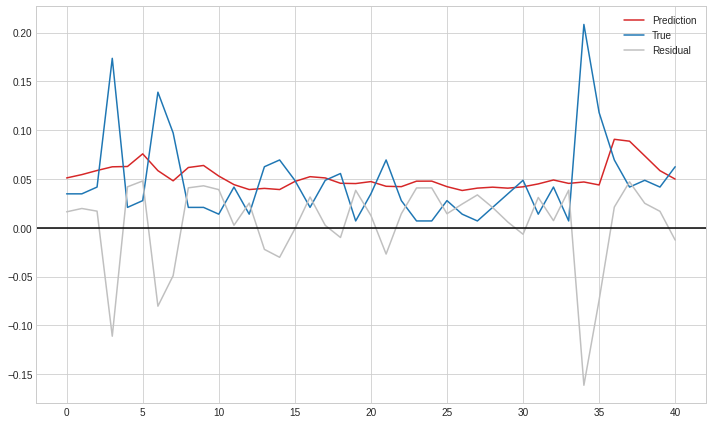

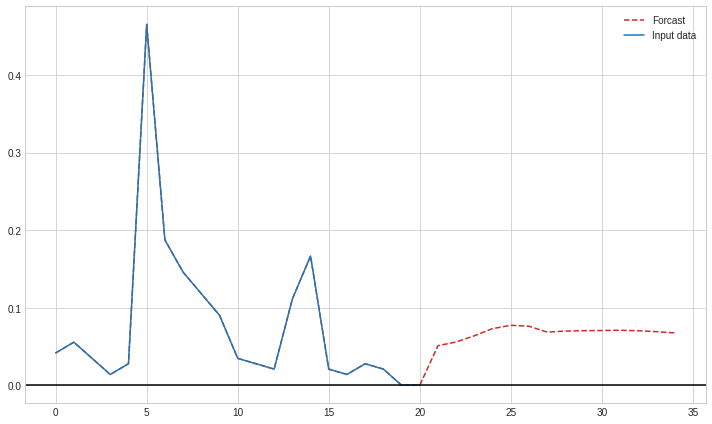



------------------------------------------------------------------------
>> Validation( 1.18s)   :   Val Loss : 0.00193     Val PPL : 1.00193
------------------------------------------------------------------------
  101    |    3     |  0.000010  | 24.214427  |  0.021809  |  1.022049 
  101    |    6     |  0.000010  | 18.948237  |  0.004131  |  1.004139 
  101    |    9     |  0.000010  | 18.890063  |  0.007776  |  1.007807 
  101    |    12    |  0.000010  | 18.808921  |  0.003726  |  1.003733 
  101    |    15    |  0.000010  | 17.929395  |  0.003296  |  1.003302 
------------------------------------------------------------------------
>> Validation( 0.34s)   :   Val Loss : 0.00222     Val PPL : 1.00222
------------------------------------------------------------------------
  102    |    3     |  0.000010  | 25.091887  |  0.021879  |  1.022120 
  102    |    6     |  0.000010  | 18.810113  |  0.003613  |  1.003620 
  102    |    9     |  0.000010  | 17.927090  |  0.006294  |  1.

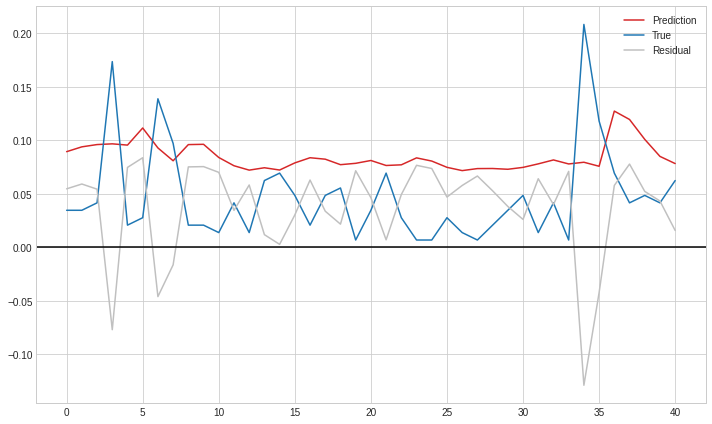

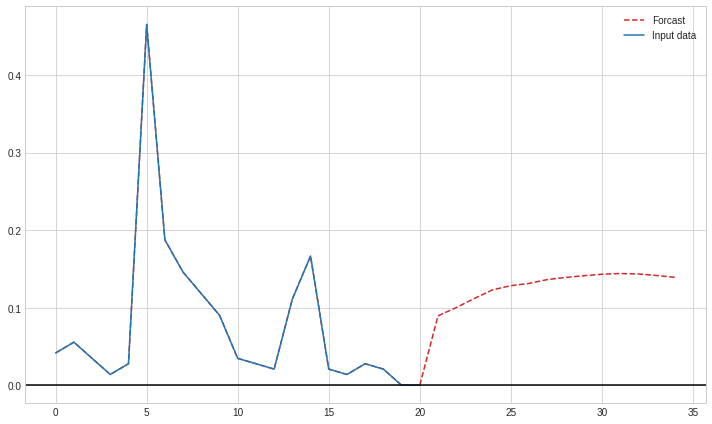



------------------------------------------------------------------------
>> Validation( 1.17s)   :   Val Loss : 0.00330     Val PPL : 1.00330
------------------------------------------------------------------------
  201    |    3     |  0.000010  | 23.326476  |  0.020796  |  1.021013 
  201    |    6     |  0.000010  | 18.820683  |  0.002385  |  1.002388 
  201    |    9     |  0.000010  | 17.897765  |  0.010322  |  1.010376 
  201    |    12    |  0.000010  | 17.839591  |  0.003835  |  1.003843 
  201    |    15    |  0.000010  | 18.481175  |  0.002279  |  1.002282 
------------------------------------------------------------------------
>> Validation( 0.33s)   :   Val Loss : 0.00186     Val PPL : 1.00186
------------------------------------------------------------------------
  202    |    3     |  0.000010  | 23.636103  |  0.020595  |  1.020809 
  202    |    6     |  0.000010  | 18.498659  |  0.002231  |  1.002234 
  202    |    9     |  0.000010  | 18.756866  |  0.005264  |  1.

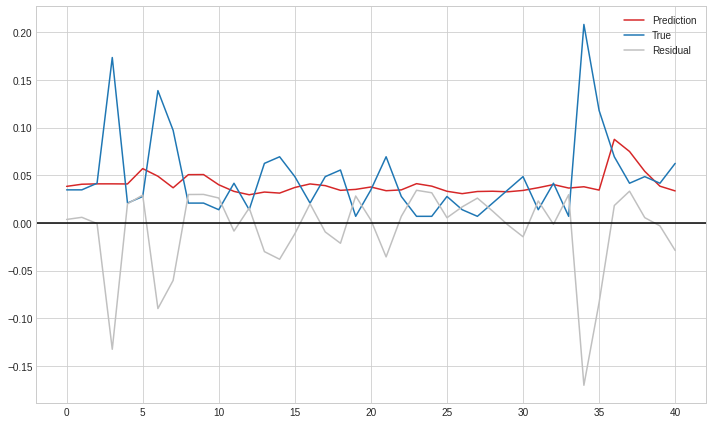

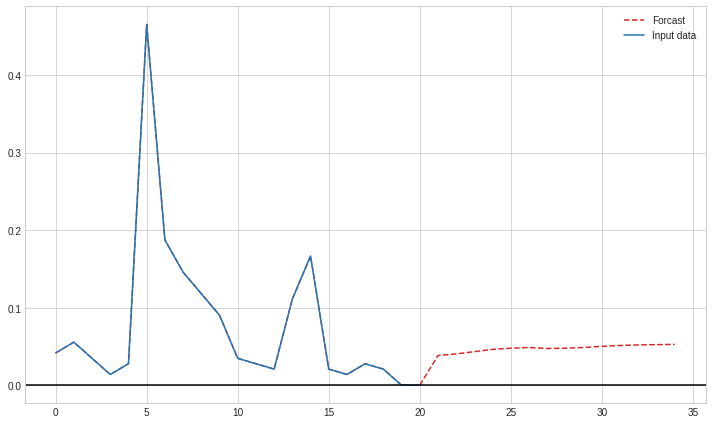



------------------------------------------------------------------------
>> Validation( 1.18s)   :   Val Loss : 0.00204     Val PPL : 1.00204
------------------------------------------------------------------------
  301    |    3     |  0.000010  | 26.352882  |  0.024344  |  1.024643 
  301    |    6     |  0.000010  | 18.193960  |  0.009886  |  1.009935 
  301    |    9     |  0.000010  | 18.654585  |  0.004226  |  1.004235 
  301    |    12    |  0.000010  | 18.578768  |  0.003197  |  1.003202 
  301    |    15    |  0.000010  | 18.059095  |  0.001013  |  1.001013 
------------------------------------------------------------------------
>> Validation( 0.34s)   :   Val Loss : 0.00272     Val PPL : 1.00272
------------------------------------------------------------------------
  302    |    3     |  0.000010  | 24.601698  |  0.019708  |  1.019903 
  302    |    6     |  0.000010  | 18.890222  |  0.003896  |  1.003904 
  302    |    9     |  0.000010  | 18.147151  |  0.005099  |  1.

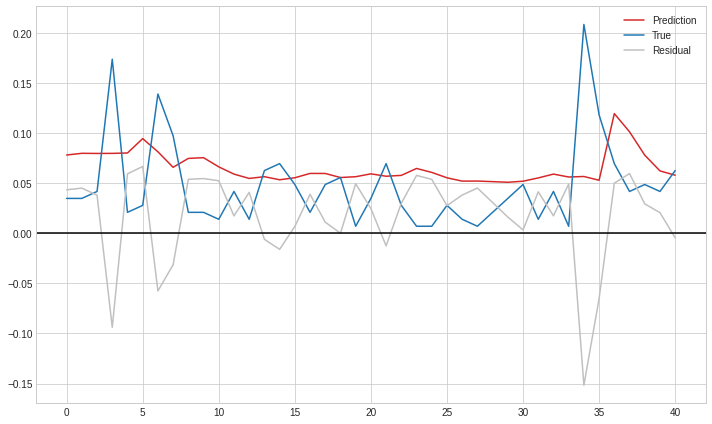

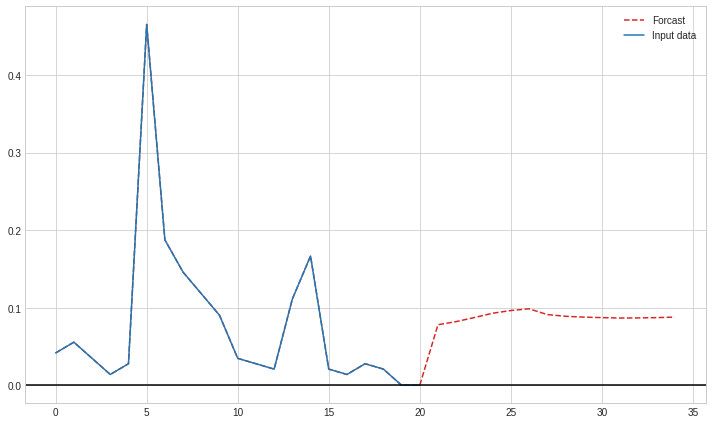



------------------------------------------------------------------------
>> Validation( 1.42s)   :   Val Loss : 0.00224     Val PPL : 1.00225
------------------------------------------------------------------------
  401    |    3     |  0.000010  | 22.928794  |  0.018007  |  1.018170 
  401    |    6     |  0.000010  | 19.240538  |  0.002212  |  1.002215 
  401    |    9     |  0.000010  | 18.256664  |  0.005740  |  1.005756 
  401    |    12    |  0.000010  | 18.200318  |  0.003046  |  1.003051 
  401    |    15    |  0.000010  | 18.149773  |  0.001068  |  1.001068 
------------------------------------------------------------------------
>> Validation( 0.33s)   :   Val Loss : 0.00191     Val PPL : 1.00191
------------------------------------------------------------------------
  402    |    3     |  0.000010  | 23.986419  |  0.017539  |  1.017693 
  402    |    6     |  0.000010  | 18.514951  |  0.001754  |  1.001755 
  402    |    9     |  0.000010  | 18.774271  |  0.004671  |  1.

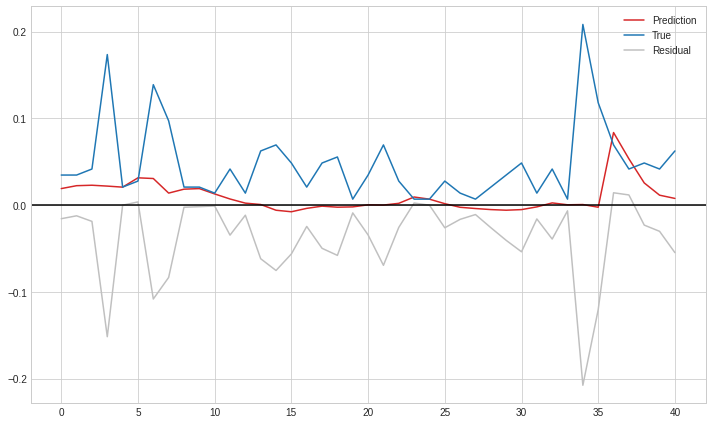

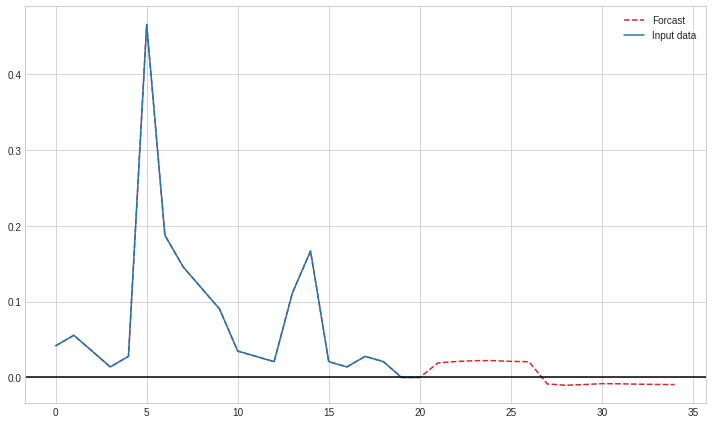



------------------------------------------------------------------------
>> Validation( 1.16s)   :   Val Loss : 0.00348     Val PPL : 1.00349
------------------------------------------------------------------------
  501    |    3     |  0.000010  | 25.302887  |  0.016637  |  1.016776 
  501    |    6     |  0.000010  | 18.184821  |  0.004480  |  1.004490 
  501    |    9     |  0.000010  | 18.177350  |  0.004542  |  1.004553 
  501    |    12    |  0.000010  | 20.197233  |  0.001815  |  1.001817 
  501    |    15    |  0.000010  | 18.033584  |  0.000604  |  1.000604 
------------------------------------------------------------------------
>> Validation( 0.34s)   :   Val Loss : 0.00224     Val PPL : 1.00225
------------------------------------------------------------------------
  502    |    3     |  0.000010  | 24.052779  |  0.017262  |  1.017412 
  502    |    6     |  0.000010  | 21.287759  |  0.002942  |  1.002947 
  502    |    9     |  0.000010  | 18.104712  |  0.004514  |  1.

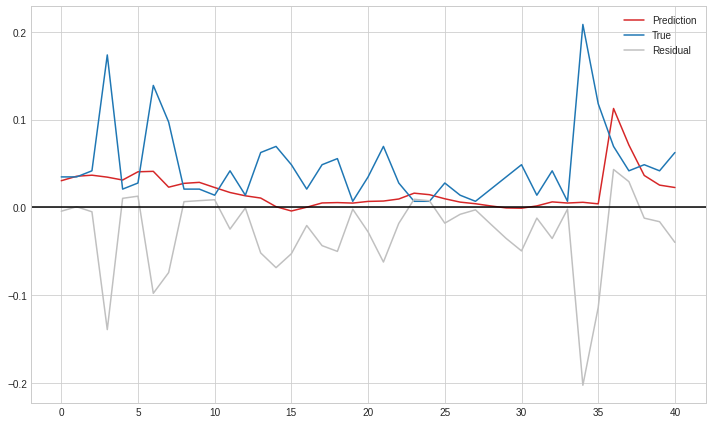

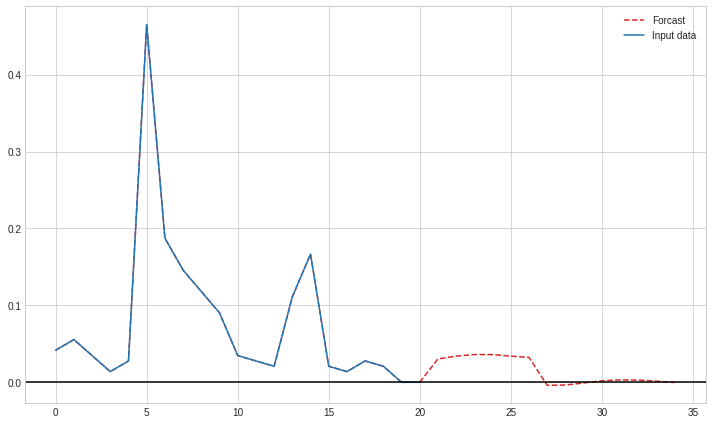



------------------------------------------------------------------------
>> Validation( 1.18s)   :   Val Loss : 0.00291     Val PPL : 1.00292
------------------------------------------------------------------------
  601    |    3     |  0.000010  | 24.276495  |  0.015191  |  1.015307 
  601    |    6     |  0.000010  | 18.929799  |  0.002803  |  1.002807 
  601    |    9     |  0.000010  | 17.658154  |  0.003721  |  1.003728 
  601    |    12    |  0.000010  | 18.761317  |  0.001730  |  1.001732 
  601    |    15    |  0.000010  | 18.231233  |  0.000458  |  1.000458 
------------------------------------------------------------------------
>> Validation( 0.33s)   :   Val Loss : 0.00194     Val PPL : 1.00194
------------------------------------------------------------------------
  602    |    3     |  0.000010  | 24.334828  |  0.014813  |  1.014923 
  602    |    6     |  0.000010  | 19.278844  |  0.001725  |  1.001727 
  602    |    9     |  0.000010  | 18.426100  |  0.004037  |  1.

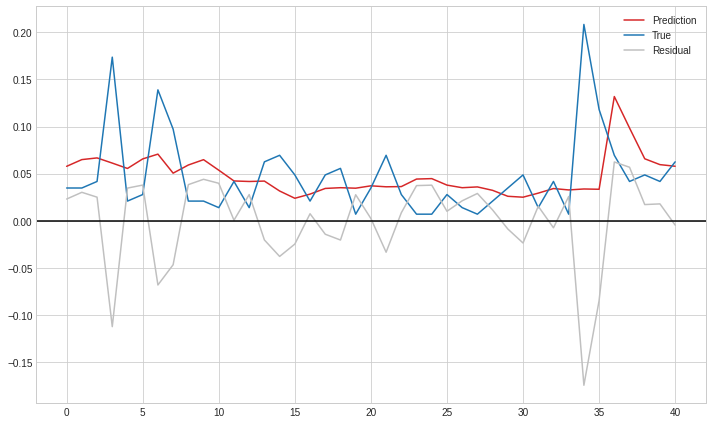

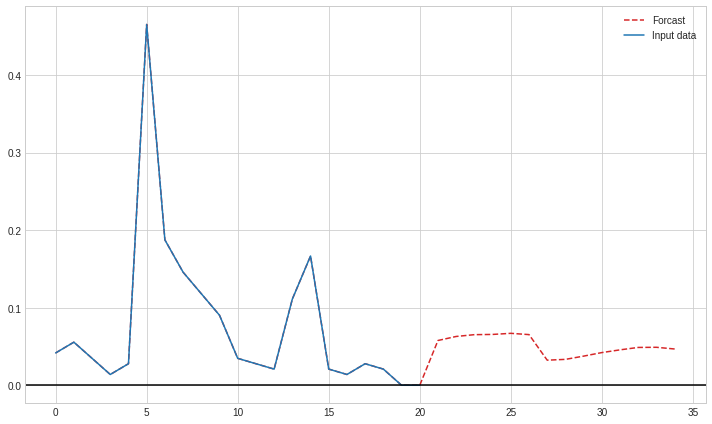



------------------------------------------------------------------------
>> Validation( 1.22s)   :   Val Loss : 0.00207     Val PPL : 1.00207
------------------------------------------------------------------------
  701    |    3     |  0.000010  | 24.185101  |  0.014962  |  1.015074 
  701    |    6     |  0.000010  | 18.416882  |  0.001498  |  1.001499 
  701    |    9     |  0.000010  | 18.543084  |  0.003804  |  1.003812 
  701    |    12    |  0.000010  | 19.456228  |  0.001247  |  1.001248 
  701    |    15    |  0.000010  | 19.231002  |  0.000447  |  1.000447 
------------------------------------------------------------------------
>> Validation( 0.34s)   :   Val Loss : 0.00302     Val PPL : 1.00302
------------------------------------------------------------------------
  702    |    3     |  0.000010  | 23.923079  |  0.015430  |  1.015549 
  702    |    6     |  0.000010  | 18.903255  |  0.003509  |  1.003516 
  702    |    9     |  0.000010  | 18.192291  |  0.004164  |  1.

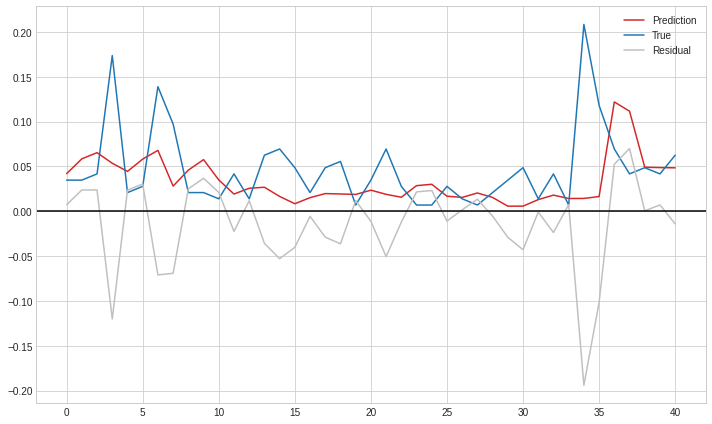

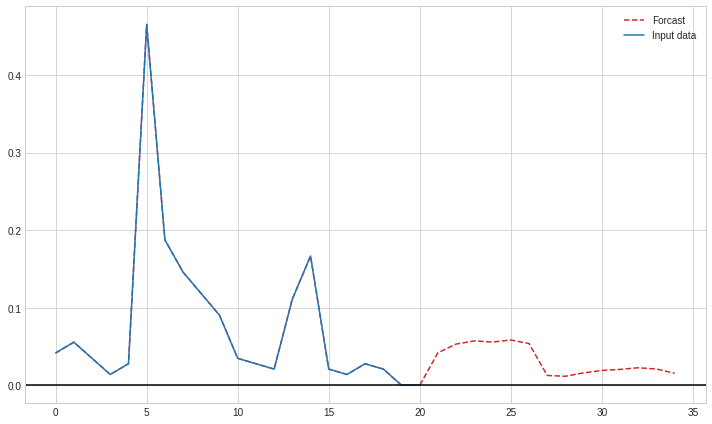



------------------------------------------------------------------------
>> Validation( 1.17s)   :   Val Loss : 0.00245     Val PPL : 1.00246
------------------------------------------------------------------------
  801    |    3     |  0.000010  | 23.740768  |  0.013084  |  1.013170 
  801    |    6     |  0.000010  | 18.793583  |  0.001732  |  1.001733 
  801    |    9     |  0.000010  | 18.495639  |  0.003585  |  1.003592 
  801    |    12    |  0.000010  | 18.464804  |  0.001157  |  1.001158 
  801    |    15    |  0.000010  | 17.560244  |  0.000388  |  1.000388 
------------------------------------------------------------------------
>> Validation( 0.33s)   :   Val Loss : 0.00252     Val PPL : 1.00252
------------------------------------------------------------------------
  802    |    3     |  0.000010  | 25.057793  |  0.013976  |  1.014074 
  802    |    6     |  0.000010  | 18.411318  |  0.001921  |  1.001923 
  802    |    9     |  0.000010  | 17.831643  |  0.003200  |  1.

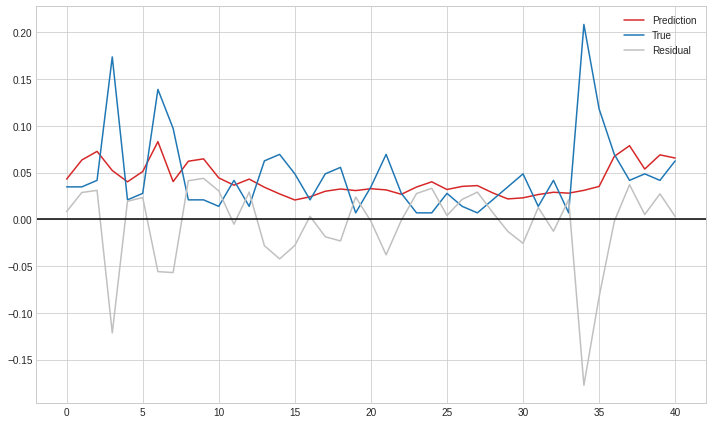

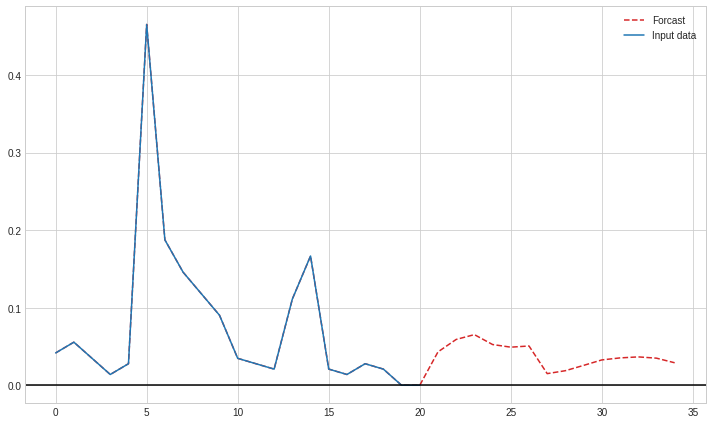



------------------------------------------------------------------------
>> Validation( 1.19s)   :   Val Loss : 0.00207     Val PPL : 1.00208
------------------------------------------------------------------------
  901    |    3     |  0.000010  | 24.430354  |  0.010937  |  1.010997 
  901    |    6     |  0.000010  | 18.564463  |  0.001499  |  1.001500 
  901    |    9     |  0.000010  | 17.754555  |  0.002127  |  1.002130 
  901    |    12    |  0.000010  | 18.374364  |  0.001262  |  1.001263 
  901    |    15    |  0.000010  | 18.411001  |  0.000288  |  1.000288 
------------------------------------------------------------------------
>> Validation( 0.33s)   :   Val Loss : 0.00234     Val PPL : 1.00234
------------------------------------------------------------------------
  902    |    3     |  0.000010  | 23.835659  |  0.010740  |  1.010798 
  902    |    6     |  0.000010  | 18.854618  |  0.001583  |  1.001584 
  902    |    9     |  0.000010  | 19.205252  |  0.002063  |  1.

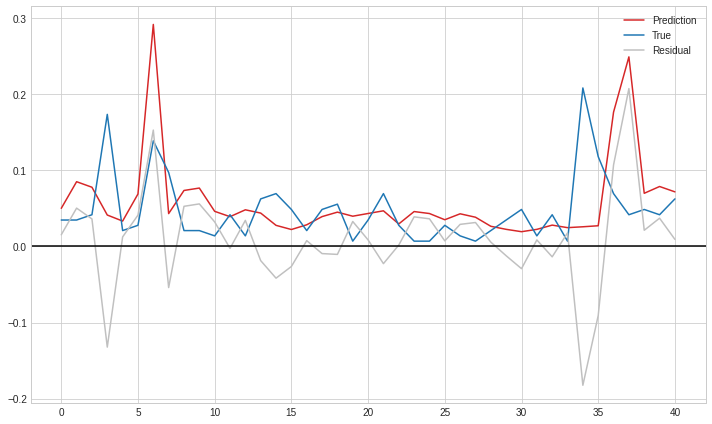

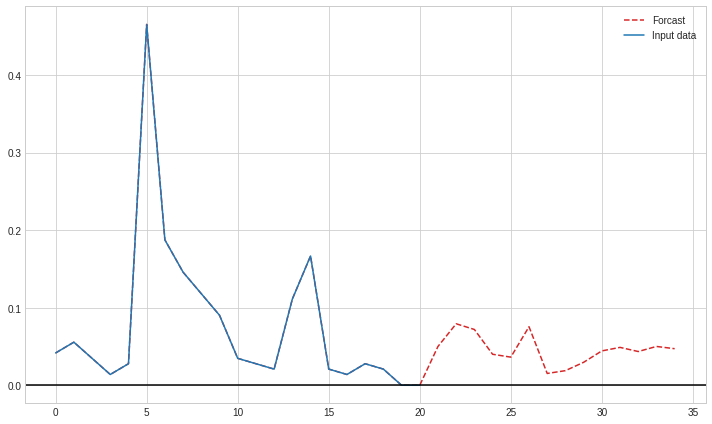



------------------------------------------------------------------------
>> Validation( 1.57s)   :   Val Loss : 0.00381     Val PPL : 1.00381
------------------------------------------------------------------------
  1001   |    3     |  0.000010  | 24.063190  |  0.004999  |  1.005012 
  1001   |    6     |  0.000010  | 18.123627  |  0.001256  |  1.001257 
  1001   |    9     |  0.000010  | 18.016259  |  0.002261  |  1.002264 
  1001   |    12    |  0.000010  | 25.855541  |  0.001025  |  1.001025 
  1001   |    15    |  0.000010  | 21.245559  |  0.000204  |  1.000204 
------------------------------------------------------------------------
>> Validation( 0.37s)   :   Val Loss : 0.00227     Val PPL : 1.00228
------------------------------------------------------------------------
  1002   |    3     |  0.000010  | 27.653853  |  0.004218  |  1.004227 
  1002   |    6     |  0.000010  | 19.971768  |  0.001232  |  1.001233 
  1002   |    9     |  0.000010  | 18.428802  |  0.001782  |  1.

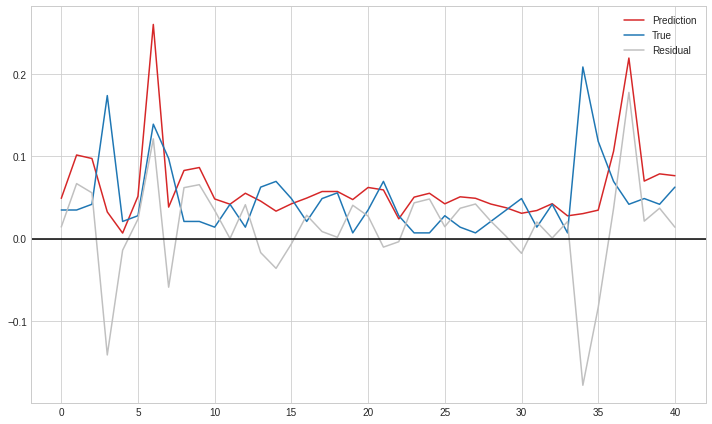

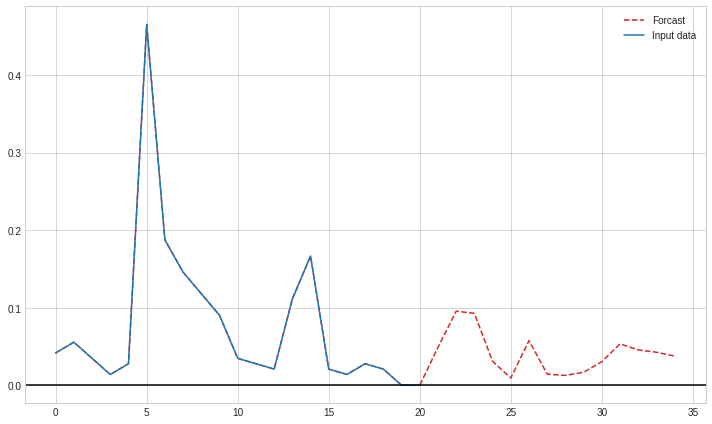



------------------------------------------------------------------------
>> Validation( 1.18s)   :   Val Loss : 0.00338     Val PPL : 1.00338
------------------------------------------------------------------------
  1101   |    3     |  0.000010  | 23.536046  |  0.004638  |  1.004649 
  1101   |    6     |  0.000010  | 18.280665  |  0.001183  |  1.001183 
  1101   |    9     |  0.000010  | 18.113534  |  0.001992  |  1.001994 
  1101   |    12    |  0.000010  | 20.039956  |  0.001067  |  1.001067 
  1101   |    15    |  0.000010  | 18.473864  |  0.000387  |  1.000387 
------------------------------------------------------------------------
>> Validation( 0.34s)   :   Val Loss : 0.00237     Val PPL : 1.00237
------------------------------------------------------------------------
  1102   |    3     |  0.000010  | 23.843447  |  0.004870  |  1.004882 
  1102   |    6     |  0.000010  | 19.889116  |  0.001179  |  1.001180 
  1102   |    9     |  0.000010  | 17.421087  |  0.001845  |  1.

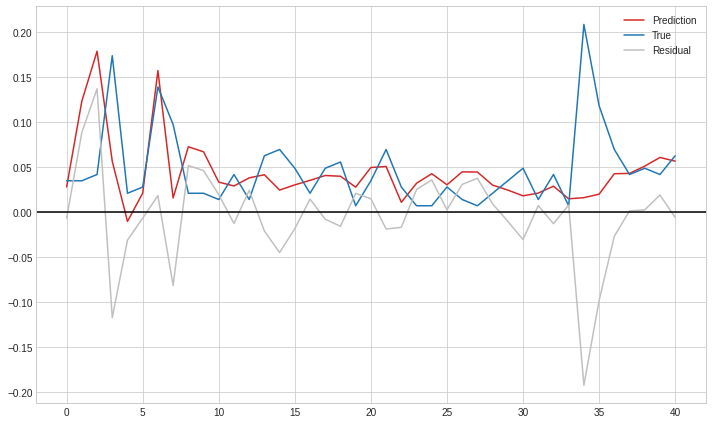

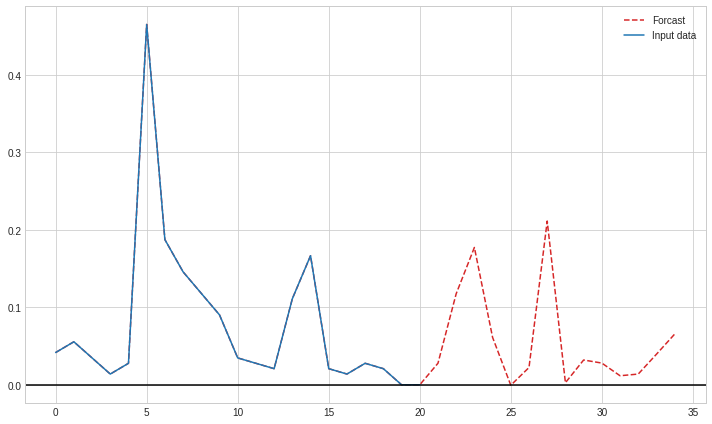



------------------------------------------------------------------------
>> Validation( 1.19s)   :   Val Loss : 0.00287     Val PPL : 1.00287
------------------------------------------------------------------------
  1201   |    3     |  0.000010  | 23.096323  |  0.005988  |  1.006006 
  1201   |    6     |  0.000010  | 17.924865  |  0.001287  |  1.001288 
  1201   |    9     |  0.000010  | 19.232273  |  0.001785  |  1.001787 
  1201   |    12    |  0.000010  | 19.012372  |  0.000854  |  1.000854 
  1201   |    15    |  0.000010  | 18.303235  |  0.000250  |  1.000250 
------------------------------------------------------------------------
>> Validation( 0.33s)   :   Val Loss : 0.00274     Val PPL : 1.00274
------------------------------------------------------------------------
  1202   |    3     |  0.000010  | 24.231593  |  0.004351  |  1.004361 
  1202   |    6     |  0.000010  | 19.157251  |  0.000990  |  1.000990 
  1202   |    9     |  0.000010  | 18.015862  |  0.002086  |  1.

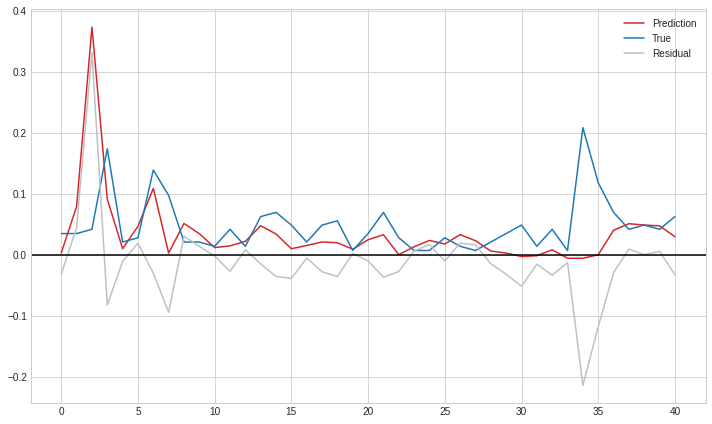

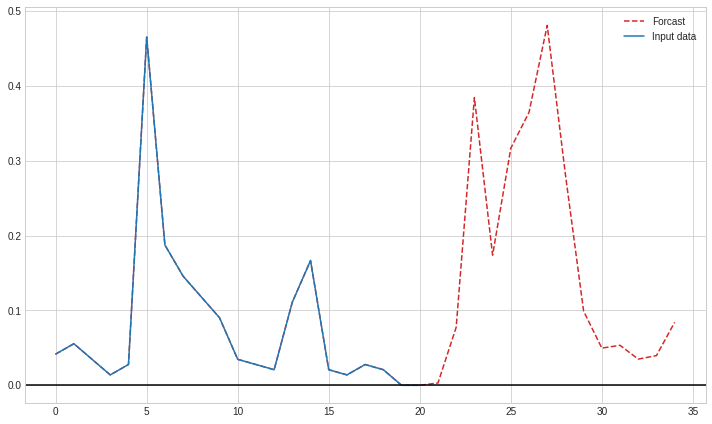



------------------------------------------------------------------------
>> Validation( 1.20s)   :   Val Loss : 0.00431     Val PPL : 1.00432
------------------------------------------------------------------------
  1301   |    3     |  0.000010  | 24.826368  |  0.003697  |  1.003704 
  1301   |    6     |  0.000010  | 18.141588  |  0.001295  |  1.001296 
  1301   |    9     |  0.000010  | 18.033187  |  0.001891  |  1.001893 
  1301   |    12    |  0.000010  | 18.712680  |  0.000980  |  1.000981 
  1301   |    15    |  0.000010  | 18.432617  |  0.000238  |  1.000238 
------------------------------------------------------------------------
>> Validation( 0.33s)   :   Val Loss : 0.00365     Val PPL : 1.00366
------------------------------------------------------------------------
  1302   |    3     |  0.000010  | 23.995082  |  0.002794  |  1.002798 
  1302   |    6     |  0.000010  | 20.039002  |  0.001049  |  1.001049 
  1302   |    9     |  0.000010  | 18.614690  |  0.001832  |  1.

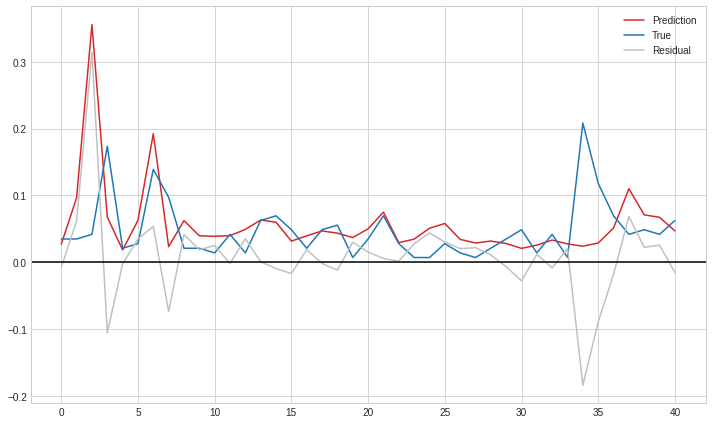

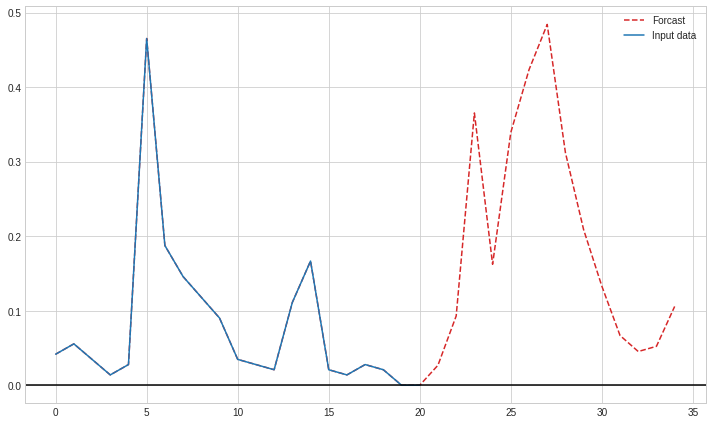



------------------------------------------------------------------------
>> Validation( 1.20s)   :   Val Loss : 0.00368     Val PPL : 1.00369
------------------------------------------------------------------------
  1401   |    3     |  0.000010  | 25.128444  |  0.002796  |  1.002800 
  1401   |    6     |  0.000010  | 17.688274  |  0.001411  |  1.001412 
  1401   |    9     |  0.000010  | 18.502474  |  0.001622  |  1.001623 
  1401   |    12    |  0.000010  | 18.670559  |  0.000764  |  1.000764 
  1401   |    15    |  0.000010  | 18.232822  |  0.000245  |  1.000245 
------------------------------------------------------------------------
>> Validation( 0.33s)   :   Val Loss : 0.00430     Val PPL : 1.00431
------------------------------------------------------------------------
  1402   |    3     |  0.000010  | 24.491628  |  0.001955  |  1.001957 
  1402   |    6     |  0.000010  | 19.197146  |  0.001295  |  1.001296 
  1402   |    9     |  0.000010  | 17.733097  |  0.001379  |  1.

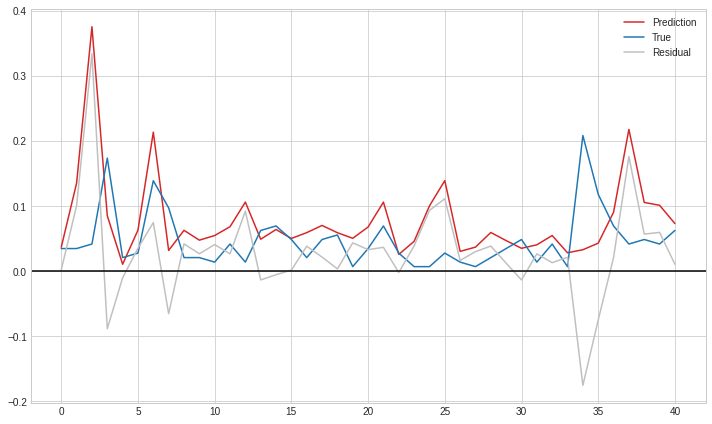

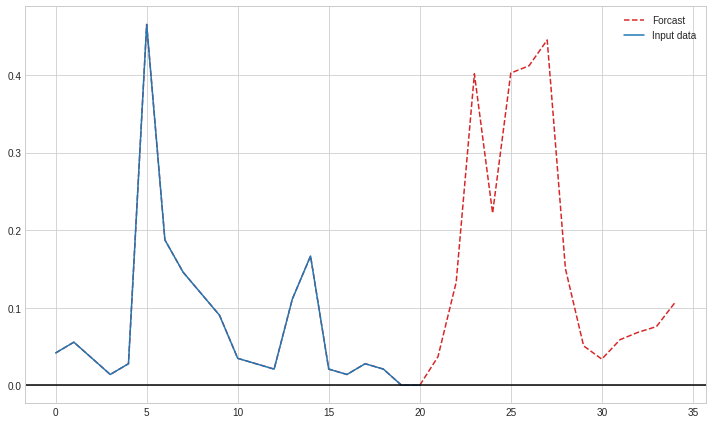



------------------------------------------------------------------------
>> Validation( 1.28s)   :   Val Loss : 0.00505     Val PPL : 1.00506
------------------------------------------------------------------------
******* Training is Done ! *******


In [ ]:
train_eval(
    train_data = train_data,
    val_data = val_data,
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler,
    epochs = 1500,
    prediction_steps = 14,   # Predict days : 2 Weeks
    )